# 6章 学習に関するテクニック
本章では、学習の効率化や過学習の対策に関する手法を学びます。

【この章の内容】
- 6.1 パラメータの更新
- 6.2 重みの初期値
- 6.3 Batch Normalization
- 6.4 正則化
- 6.5 ハイパーパラメータの検証
- 6.6 まとめ
<br><br>
まず、この章で利用するライブラリを読み込みます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys, os
sys.path.append(os.pardir)
from utils.mnist import load_mnist
from utils.multi_layer_net import MultiLayerNet
from utils.multi_layer_net_extend import MultiLayerNetExtend
from utils.layers import *
from utils.util import smooth_curve


## 6.1 パラメータの更新

これまで、損失関数の値を小さくするために確率的勾配降下法(stochastic gradient descent)---SGDを用いていました。ここでは、SGDの欠点を確認し、それとは別の最適化手法を学びます。

### 6.1.2 SGD

- 更新式の確認<br>
重みパラメータを$\mathbf{W}$、損失関数を$L$、$\mathbf{W}$についての損失関数の勾配を$\frac{\partial L}{\partial \mathbf{W}}$とすると、SGDは次のように書けます。
$$
\mathbf{W}
    \leftarrow
        \mathbf{W}
            - \eta
                \frac{\partial L}{\partial \mathbf{W}}
\tag{6.1}
$$
$\eta$は学習率です。また、$\leftarrow$は右辺の値で左辺の値を更新することを表しています。

- 実装

In [2]:
#SGDの実装
class SGD:
    
    def __init__(self, lr=0.01):
        self.lr = lr # 学習率
    
    # パラメータの更新メソッド
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] # 式(6.1)

### 6.1.3 SGDの欠点

次の関数の最小値を求める問題を考える。
$$
f(x, y)
    = \frac{1}{20} x^2
        + y^2
\tag{6.2}
$$

In [3]:
# (6.2)の実装
def function(x, y):
    return x ** 2 / 20 + y ** 2

#(6.2)の勾配を解析的に与える
def df(x, y):
    dx = x / 10.0 # df/dx
    dy = 2.0 * y # df/dy
    return dx, dy


図6-1のように、プロットしてみる。

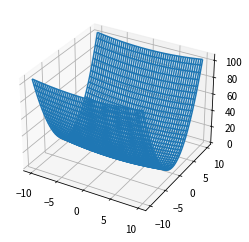

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d') 
x = np.arange(-10.0, 10.0, 0.1)
y = np.arange(-10.0, 10.0, 0.1)
X, Y = np.meshgrid(x, y) # 格子点の作成
Z = function(X, Y)
ax.plot_wireframe(X, Y, Z)
plt.show()

図6-1の等高線

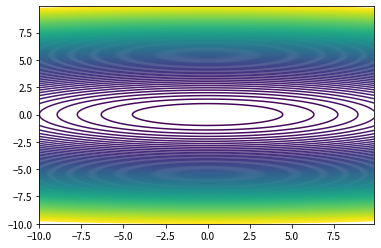

In [5]:
h = np.arange(0., 100.0, 1.0)
Z = function(X, Y)

plt.figure()
plt.contour(X, Y, Z, levels=h)
plt.show()

図6-2の勾配

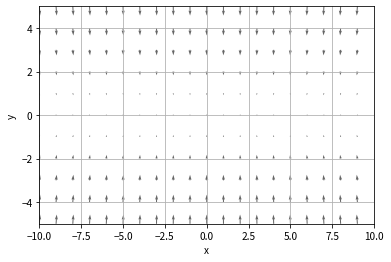

In [6]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 値を元に戻す
    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        return grad

def function_2(x):
    return (x[0]**2/20+x[1]**2)

x = np.arange(-10.0, 10.0, 1.)
y = np.arange(-10.0, 10.0, 1.)
h = np.arange(0., 100.0, 10.0)
X, Y = np.meshgrid(x, y)

X = X.flatten()
Y = Y.flatten()
grad = numerical_gradient(function_2, np.array([X, Y]).T).T

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.draw()
plt.show()

この関数の勾配を見てみると、$x$軸方向に小さく、$y$軸方向に大きいことがわかります。それでは、この関数について最小値をSDGによって探索してみましょう。なお、初期値は$(-7,2)$とします。

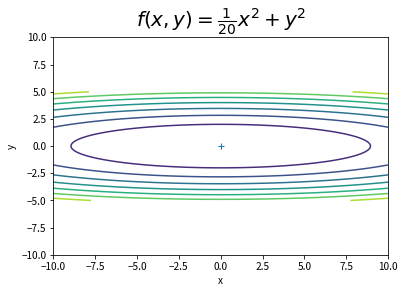

In [7]:
# 等高線用の値
x = np.arange(-10, 10, 0.01) # x軸の値
y = np.arange(-5, 5, 0.01) # y軸の値
X, Y = np.meshgrid(x, y) # 格子状の点に変換
Z = function(X, Y)

# 作図
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("$f(x, y) = \\frac{1}{20} x^2 + y^2$", fontsize=20) # タイトル
plt.show()

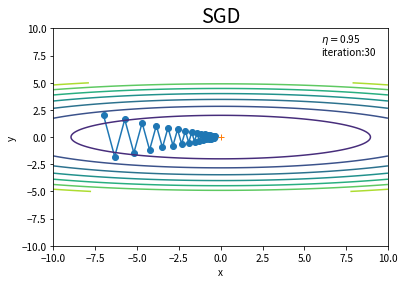

In [8]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.95

# インスタンスを作成
optimizer = SGD(lr=lr)
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    # 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("SGD", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\niteration:" + str(iter_num)) # メモ
plt.show()

今回の設定では図のようなジグザグな経路をたどっています。当然、非効率的な探索になっています。これは、最小値に向いていない勾配があることに起因しています。このことより、SGDは等方的な傾きを持たない関数だと、ジグザグな経路を辿る可能性があることがわかります。また、学習率や試行回数を変えるとどのような振舞いをするのか試してみます。

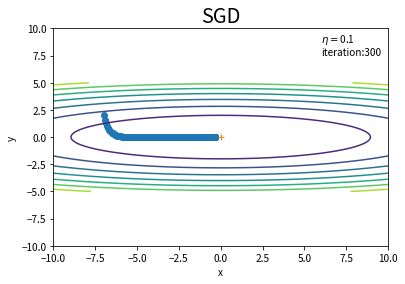

In [9]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.1

# インスタンスを作成
optimizer = SGD(lr=lr)
# 試行回数を指定
iter_num = 300

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    # 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("SGD", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\niteration:" + str(iter_num)) # メモ
plt.show()

もちろん学習率を小さくすると経路は改善されましたが、その分所要計算回数は大きくなります。

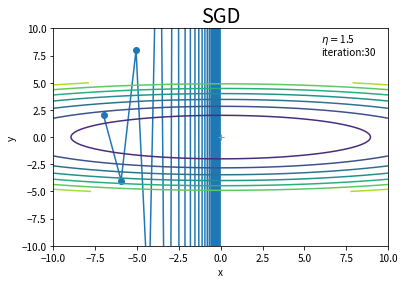

In [10]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 1.5

# インスタンスを作成
optimizer = SGD(lr=lr)
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    # 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("SGD", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\niteration:" + str(iter_num)) # メモ
plt.show()

また、学習率を大きくすると、発散してしまいます。

### 6.1.4 Momentum

Momentumとは運動量という意味の言葉です。物理では、
$$
\bm{F}
    =\frac{d\bm{p}}{dt}
$$
運動方程式にあらわれる、$\bm{p}(=m\bm{v})$です。
では、手法を確認します。
- 更新式
$$
\mathbf{v}
    \leftarrow
      \alpha \mathbf{v}
      - \eta
        \frac{\partial L}{\partial \mathbf{W}}
\tag{6.3}
$$
$$
\mathbf{W}
    \leftarrow
      \mathbf{W} + \mathbf{v}
\tag{6.4}
$$

これだけでは少しわかりづらいため、初回の更新について考えます。初回の更新は$\mathbf{v}^{(1)} = \alpha \mathbf{v}^{(0)} - \eta \frac{\partial L}{\partial \mathbf{W}^{(0)}}$と表せます。また、$\mathbf{v}^{(0)}$を$0$とすると、
$$
\mathbf{v}^{(1)}
    = - \eta
        \frac{\partial L}{\partial \mathbf{W}^{(0)}}
$$

になります。

次に2回目の更新を考えます。二回目の更新は$\mathbf{v}^{(2)} = \alpha \mathbf{v}^{(1)} - \eta \frac{\partial L}{\partial \mathbf{W}^{(1)}}$と書けるのでこれに$\mathbf{v}^{(1)}$を代入すると、
$$
\mathbf{v}^{(2)}
    = - \alpha \eta
        \frac{\partial L}{\partial \mathbf{W}^{(0)}}
      - \eta
        \frac{\partial L}{\partial \mathbf{W}^{(1)}}
$$

となります。これを同様に繰り返し、$T$回目の更新を求めると、
$$
\begin{align*}
\mathbf{W}^{(T)}
   &= \mathbf{W}^{(T-1)} + \mathbf{v}^{(T)}
\\
   &= \mathbf{W}^{(T-1)}
      - \eta
        \sum_{t=1}^T
          \alpha^{T-t}
          \frac{\partial L}{\partial \mathbf{W}^{(t-1)}}
\end{align*}
$$
となります。\
つまり、Momentumでは、過去の勾配の情報を$\mathbf{v}$として保持しています。そのため、関数(6.2)のような$x$軸方向の勾配が小さくても、更新するにしたがって徐々に足されていき、その重みは大きくなります。もちろん、$y$軸方向のほうが大きい勾配を持っていますが、正と負の方向で交互に足されることにより、互いに打ち消し合うことにより、その重みは小さくなっていきます。
- 実装

In [11]:
# Momentumの実装
class Momentum:
    
    # インスタンス変数を定義
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr # 学習率
        self.momentum = momentum # vの調整項
        self.v = None # 速度
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # vを初期化
        if self.v is None: # 初回のみ
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key] # 式(6.3)
            params[key] += self.v[key] # 式(6.4)

In [12]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.1

# モーメンタムを指定
momentum = 0.9

# インスタンスを作成
optimizer = Momentum(lr=lr, momentum=momentum)

In [13]:
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])

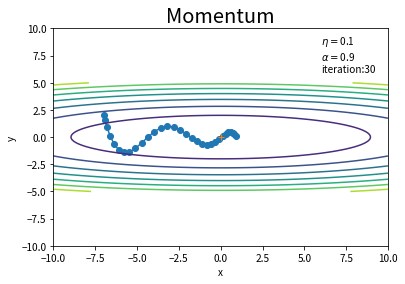

In [14]:
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("Momentum", fontsize=20) # タイトル
plt.text(6, 6, "$\\eta=$" + str(lr) + "\n$\\alpha=$" + str(momentum) + "\niteration:" + str(iter_num)) # メモ
plt.show()


### 6.1.5 AdaGrad

学習率について、これまで見てきた通り、小さすぎると計算量が大きくなり、大きすぎると発散してしまうという悩ましい問題があります。AdaGradはこの問題を解決するべく各要素ごとに適応的に学習率を調節しながらできる手法です。
- 更新式
$$
\mathbf{h}
    \leftarrow
      \mathbf{h}
      + \frac{\partial L}{\partial \mathbf{W}}
        \odot \frac{\partial L}{\partial \mathbf{W}}
\tag{6.5}
$$
$$
\mathbf{W}
    \leftarrow
      \mathbf{W}
      - \eta
        \frac{1}{\sqrt{\mathbf{h}}}
        \frac{\partial L}{\partial \mathbf{W}}
\tag{6.6}
$$
ここで$\odot$は行列の要素毎の乗算を意味します。
先ほどと同様にT回目の更新を考えてみます。例として$j,k$成分について考えてみます。
$$
\begin{align*}
h_{jk}^{(1)}
    &= \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(0)}}
      \Bigr)^2
\\
h_{jk}^{(2)}
    &= \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(0)}}
      \Bigr)^2
      + \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(1)}}
      \Bigr)^2
\\
\dots
\\
h_{jk}^{(T)}
   &= \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(0)}}
      \Bigr)^2
      + \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(1)}}
      \Bigr)^2
      + \cdots
      + \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(T-1)}}
      \Bigr)^2
\\
   &= \sum_{t=1}^T
          \Bigl(
              \frac{\partial L}{\partial w_{jk}^{(t-1)}}
          \Bigr)^2
\end{align*}
$$
これを用いて、$w_{jk}$の$T$更新値は、
$$
\begin{align*}
w_{jk}^{(T)}
   &= w_{jk}^{(T-1)}
      - \eta
        \frac{1}{\sqrt{h_{jk}^{(T)}}}
        \frac{\partial L}{\partial w_{jk}^{(T-1)}}
\\
   &= w_{jk}^{(T-1)}
      - \eta
        \frac{
            1
        }{
            \sqrt{
                \sum_{t=1}^T
                    \Bigl(\frac{\partial L}{\partial w_{jk}^{(t-1)}}\Bigr)^2
            }
        }
        \frac{\partial L}{\partial w_{jk}^{(T-1)}}
\end{align*}
$$
となります。
- 実装

In [15]:
# AdaGradの実装
class AdaGrad:
    
    # インスタンス変数を定義
    def __init__(self, lr=0.01):
        self.lr = lr # 学習率
        self.h = None # 過去の勾配の2乗和
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # hの初期化
        if self.h is None: # 初回のみ
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # 式(6.5)
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 式(6.6)

In [16]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 1.5

# インスタンスを作成
optimizer = AdaGrad(lr=lr)

In [17]:
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])

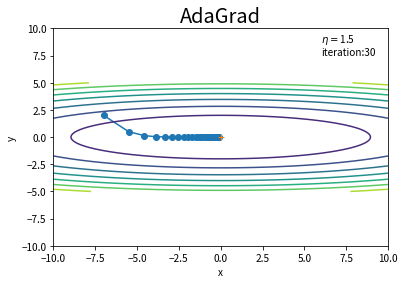

In [18]:
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("AdaGrad", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\niteration:" + str(iter_num)) # メモ
plt.show()

### 6.1.6 Adam

AdamはMomentumとAdaGradのアイデアを合わせたような手法です。
- 更新式
$$
\mathbf{m}
    \leftarrow
      \beta_1 \mathbf{m}
      + (1 - \beta_1)
        \frac{\partial L}{\partial \mathbf{W}}
\tag{1}
$$
$$
\mathbf{v}
    \leftarrow
      \beta_2 \mathbf{v}
      + (1 - \beta_2)
        \frac{\partial L}{\partial \mathbf{W}}
        \odot \frac{\partial L}{\partial \mathbf{W}}
\tag{2}
$$
$$
\begin{align}
\hat{\mathbf{m}}
   &= \frac{\mathbf{m}}{1 - \beta_1^t}
\tag{3}\\
\hat{\mathbf{v}}
   &= \frac{\mathbf{v}}{1 - \beta_2^t}
\tag{4}
\end{align}
$$
$$
\mathbf{W}
    \leftarrow
      - \eta
        \frac{
            \hat{\mathbf{m}}
        }{
            \sqrt{\hat{\mathbf{v}}} + \epsilon
        }
\tag{5}
$$
$$
\mathbf{W}
    \leftarrow
      \mathbf{W}
      - \eta
        \frac{\sqrt{1 - \beta_2^t}}{1 - \beta_1^t}
        \frac{\mathbf{m}}{\sqrt{\mathbf{v}} + \epsilon}
\tag{6}
$$

- 実装

In [19]:
# Adamの実装
class Adam:

    # インスタンス変数を定義
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr # 学習率
        self.beta1 = beta1 # mの減衰率
        self.beta2 = beta2 # vの減衰率
        self.iter = 0 # 試行回数を初期化
        self.m = None # モーメンタム
        self.v = None # 適合的な学習係数
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # mとvを初期化
        if self.m is None: # 初回のみ
            self.m = {}
            self.v = {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val) # 全ての要素が0
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        self.iter += 1 # 更新回数をカウント
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter) # 式(6)の学習率の項
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key] # 式(1)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # 式(2)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # 式(6)

In [20]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.3

# 減衰率を指定
beta1 = 0.9
beta2 = 0.999

# インスタンスを作成
optimizer = Adam(lr=lr, beta1=beta1, beta2=beta2)


In [21]:
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])

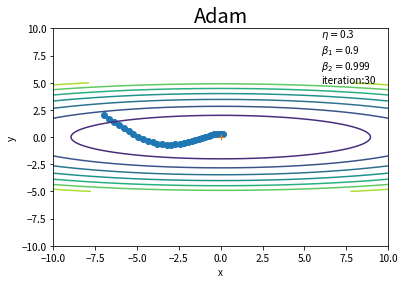

In [22]:
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("Adam", fontsize=20) # タイトル
plt.text(6, 5, "$\\eta=$" + str(lr) + "\n$\\beta_1=$" + str(beta1) + 
         "\n$\\beta_2=$" + str(beta2) + "\niteration:" + str(iter_num)) # メモ
plt.show()

### 6.1.7 どの更新手法を用いるか？

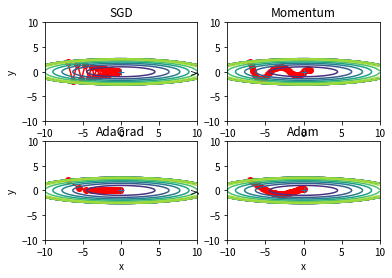

In [23]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from utils.optimizer import *

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### 6.1.8 MNISTデータセットによる更新手法の比較

In [24]:
# この項で利用するライブラリを読み込む
import numpy as np
import matplotlib.pyplot as plt

# データ読み込み用ライブラリを読み込む
import sys, os

# ファイルパスを指定
sys.path.append(os.pardir)

# MNISTデータセット読み込み関数を読み込む
from utils.mnist import load_mnist

# 多層ニューラルネットワーククラスを読み込む
from utils.multi_layer_net import MultiLayerNet

# 画像データを読み込む
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [25]:
# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズ指定
batch_size = 128

# 試行回数を指定
max_iterations = 2001

In [26]:
# 各手法のインスタンスをディクショナリ変数に格納
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
print(optimizers.keys())

dict_keys(['SGD', 'Momentum', 'AdaGrad', 'Adam'])


In [27]:
# 手法ごとにディクショナリ変数に格納
networks = {}
train_loss = {}
for key in optimizers.keys():
    # 多層ニューラルネットワーク
    networks[key] = MultiLayerNet(
        input_size=784, 
        hidden_size_list=[100, 100, 100, 100],
        output_size=10
    )
    
    # 交差エントロピー誤差の受け皿
    train_loss[key] = []

In [28]:
# 手書き文字認識
for i in range(max_iterations):
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 手法ごとに学習
    for key in optimizers.keys():
        # 勾配を計算
        grads = networks[key].gradient(x_batch, t_batch)
        
        # パラメータを更新
        optimizers[key].update(networks[key].params, grads)
        
        # 損失関数の計算
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss) # 交差エントロピー誤差を記録
    
    # (動作確認も兼ねて)100回ごとに損失関数の値を表示
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            print(
                key + " " * (8 - len(key)) + ":" + # (`8`は`key`の最大文字数)
                str(np.round(train_loss[key][i], 5))
            )

===========iteration:0===========
SGD     :2.34469
Momentum:2.41565
AdaGrad :2.20886
Adam    :2.21381
===========iteration:100===========
SGD     :1.44542
Momentum:0.2771
AdaGrad :0.10669
Adam    :0.21426
===========iteration:200===========
SGD     :0.71531
Momentum:0.21302
AdaGrad :0.10666
Adam    :0.18763
===========iteration:300===========
SGD     :0.52029
Momentum:0.17605
AdaGrad :0.05606
Adam    :0.12061
===========iteration:400===========
SGD     :0.3471
Momentum:0.09108
AdaGrad :0.03746
Adam    :0.05665
===========iteration:500===========
SGD     :0.43306
Momentum:0.2117
AdaGrad :0.08295
Adam    :0.12372
===========iteration:600===========
SGD     :0.37468
Momentum:0.13476
AdaGrad :0.05328
Adam    :0.08537
===========iteration:700===========
SGD     :0.2457
Momentum:0.07279
AdaGrad :0.03638
Adam    :0.06176
===========iteration:800===========
SGD     :0.33464
Momentum:0.13478
AdaGrad :0.03485
Adam    :0.0825
===========iteration:900===========
SGD     :0.26951
Momentum:0.08333
A

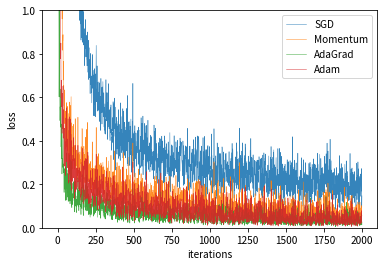

In [29]:
# 作図用のx軸の点
iterations = np.arange(max_iterations)

# 作図
for key in optimizers.keys():
    plt.plot(iterations, train_loss[key], label=key, linewidth=0.5, alpha=0.9)
plt.xlabel("iterations") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.ylim(0, 1) # y軸の範囲
plt.legend() # 凡例
plt.show()

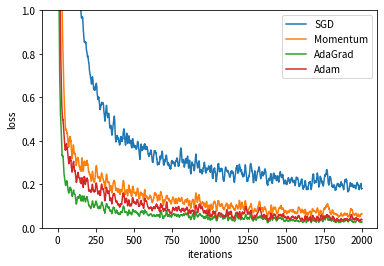

In [30]:
# 作図用のx軸の点
iterations = np.arange(max_iterations)

# 作図
for key in optimizers.keys():
    plt.plot(iterations, smooth_curve(train_loss[key]), label=key)
plt.xlabel("iterations") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.ylim(0, 1) # y軸の範囲
plt.legend() # 凡例
plt.show()

## 6.2 重みの初期値

学習の成否に大きくかかわる重みの初期値について考えます。

### 6.2.1 重みの初期値を0にする？

過学習とはモデルが訓練データにフィットし過ぎてしまい、未知のデータに対する予測ができなくなってしまう現象のことです。のちに学びますが、過学習が起こる条件のひとつにはモデルの表現力が高すぎることが挙げられます。この原因の一つには、重みパラメータの値が大きくなりすぎることが挙げられます。シンプルな過学習の例を見てみたいと思います。

<function matplotlib.pyplot.show(close=None, block=None)>

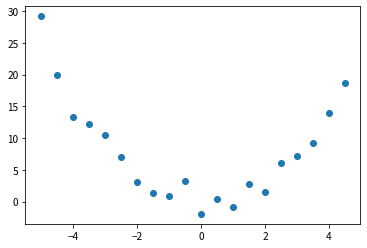

In [31]:
# ばらつきを持った2次関数の波形を生成
x = np.arange(-5, 5,0.5)                             # x軸配列を作成
noise = np.random.normal(loc=0, scale=2, size=len(x)) # ガウシアンノイズを生成
y =x ** 2 + noise                 # 2次関数にノイズを乗せる

plt.scatter(x, y)
plt.show

二次曲線にガウシアンノイズを乗せて生成したデータを用意しました。このデータを最小二乗法を用いて、多項曲線にフィッティングしてみます。二次では以下の式の係数$a,b,c$を最小二乗法により求めるということです。
$$
y=ax^2+bx+c
$$

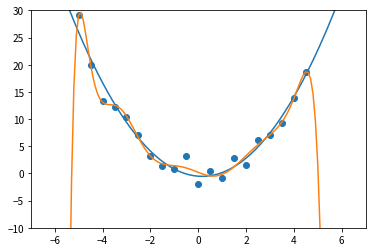

In [32]:
# 得られたパラメータからカーブフィット後の波形を作成
w_s = np.polyfit(x, y, 2)
w_o = np.polyfit(x, y, 12)
func_simple = np.poly1d(w_s)
func_over = np.poly1d(w_o)


s = np.arange(-7, 7,0.1)  

plt.scatter(x,y,marker='o')
plt.plot(s, func_simple(s))
plt.plot(s, func_over(s))
plt.xlim(-7,7)
plt.ylim(-10, 30)
plt.show()

In [33]:
print(w_s)
print(w_o)
print(np.sum(abs(w_s)))
print(np.sum(abs(w_o)))

[ 0.99373166 -0.32648259 -0.5119717 ]
[-3.57606718e-06  1.22274910e-05  1.94344963e-04 -9.40919793e-04
 -3.32049522e-03  2.49370918e-02  1.41181516e-02 -2.76056647e-01
  9.36480694e-02  1.20021627e+00  3.30339198e-01 -1.74215889e+00
  1.92955267e-01]
1.8321859397490434
3.8789011440171492


ここで係数の大きさに注目すると、過学習のモデルでは二次関数のモデルに比べ、係数の絶対値の和が大きくなることがほとんどです。この特徴を用いると、過学習の指標の一つとして重みの大きさを用いることができるといえるかと思います。そのため、重みの初期値もできるだけ小さくすることにより過学習を抑制することができます。しかし、そのために初期値をすべて0に設定してしまうと、
    

### 6.2.2 隠れ層のアクティベーション分布

ここでは重みの初期値の影響を見るために、活性化関数からの出力データ(＝アクティベーション)の分布を観察します。実験として、隠れ層を5層にして、それぞれの層は100個のニューロンを持つものとします。活性化関数をシグモイド関数として設定します。

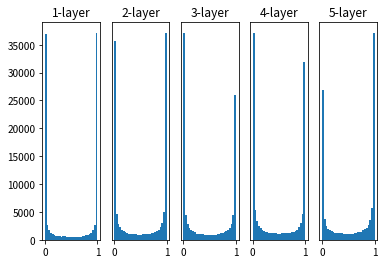

In [34]:
#シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1 #標準偏差=1
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

すべての層で0、1に偏ったアクティベーションの分布になっています。シグモイド関数は0、1で微分が0に近づくため逆伝播での勾配の値が小さくなって消えてしまいます。これを$\bf{勾配消失}$といいます。\
では、標準偏差を変えて同じを実験してみます。

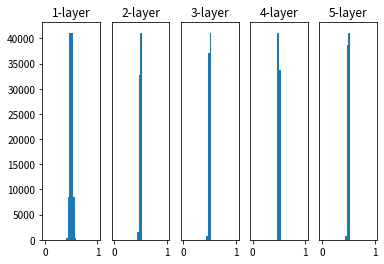

In [35]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01 #標準偏差=0.01
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

標準偏差を0.01とした場合どの層も0.5付近に偏る分布になりました。勾配消失の問題は生じませんが、これでは各層ですべてのニューロンが同じ値を出力することになり、表現力に問題が生じます。\
その問題を解決すべく、ここで「Xavierの初期値」というものを導入します。Xavierの初期値とは、前層のノード数を$n$とすると$\frac{1}{\sqrt{n}}$の標準偏差を持つ分布に従う初期値のことです。

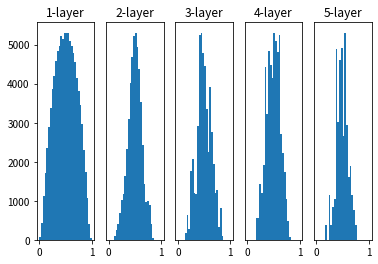

In [36]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #標準偏差=sqrt(1/n)=0.1
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

これまでよりも広がりを持った分布になりました。

### 6.2.3 ReLUの場合の重みの初期化

次は活性化関数にReLU関数を用いる場合を確認します。

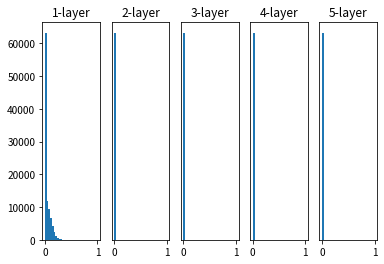

In [37]:
# ReLU関数
def relu(x):
    return np.maximum(0, x)

x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01 #標準偏差=0.01
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

ReLU関数は負の値が全て0になるため0が多くなるのは当然の結果ですが、0以外の値がほとんど現れていません。続いて「Xavierの初期値」の結果を見てみます。

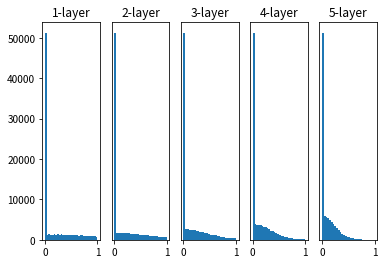

In [38]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #標準偏差=sqrt(1/n)=0.1
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

第1層の出力時は値が均一に分布していますが、層が進むごとに小さい値に分布が偏っていきます。そこでReLU関数には「Heの初期値」と呼ばれる初期値を用いてみます。これは前層のノード数を$n$とすると$\frac{2}{\sqrt{n}}$の標準偏差を持つ分布に従う初期値のことです。

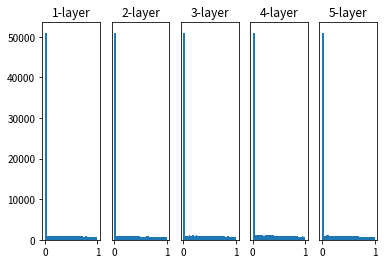

In [39]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # Heの初期値
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

各層のアクティベーションの分布は均一になりました。

### 6.2.4 MNISTデータセットによる重み初期値の比較

ここでは、3種類の重みの初期値の与え方によって、学習(交差エントロピー誤差推移)にどのように影響するのかを確認します。活性化関数はReLUを使用します。

===========iteration:0===========
std=0.01:2.3024910862455377
Xavier:2.3076592565268044
He:2.2707892269795287
===========iteration:100===========
std=0.01:2.3025387519545815
Xavier:2.243538089578627
He:1.5932933857704281
===========iteration:200===========
std=0.01:2.3007804123251967
Xavier:2.1374440933911263
He:0.7951102635626665
===========iteration:300===========
std=0.01:2.302970497137125
Xavier:1.8744133806627303
He:0.5547035488909107
===========iteration:400===========
std=0.01:2.303254410258205
Xavier:1.3641380834434704
He:0.4142668343688466
===========iteration:500===========
std=0.01:2.2980617097703204
Xavier:0.9096794438252598
He:0.2912692552923146
===========iteration:600===========
std=0.01:2.3030409086416412
Xavier:0.6983724110280385
He:0.378936540360878
===========iteration:700===========
std=0.01:2.3012592542944814
Xavier:0.5871763660709217
He:0.3506322419484416
===========iteration:800===========
std=0.01:2.303126467419025
Xavier:0.4391387542344694
He:0.2161409312429829

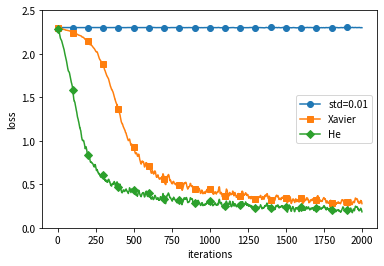

In [40]:
# MNISTデータの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# ディクショナリを作成
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 6.3 Batch Normalization

前節では重みの初期値の設定の工夫によりアクティベーションの分布の広がりを保つ手法を学びました。ここではアクティベーションに工夫を加えることで分布を調節する手法を考えます。

### 6.3.1 Batch Normalizationのアルゴリズム

Batch Normとはミニバッチごとに標準化することです。ミニバッチデータの分布が平均が0で標準偏差が1になるようにすることです。Batch Normには次の利点があります。
- 学習を速く進行させられる
- 初期値にそれほど依存しない
- 過学習を抑制する

では、アルゴリズムを確認します。データ数が
$m$のミニバッチデータを$B = \{x_1, x_2, \cdots, x_m\}$とすると、次の式で表せます。
$$
\begin{align*}
\mu_B
   &\leftarrow
      \frac{1}{m}
      \sum_{i=1}^m
          x_i
\\
\sigma_B^2
   &\leftarrow
      \frac{1}{m}
      \sum_{i=1}^m
          (x_i - \mu_B)^2
\\
\hat{x}_i
   &\leftarrow
      \frac{
          x_i - \mu_B
      }{
          \sqrt{\sigma_B^2 + \epsilon}
      }
\tag{6.7}
\end{align*}
$$
なお$\epsilon$0で割ることを防止するための微小な値です。これは、ミニバッチ毎に標準化を行っています。さらに、Batch Normでは、この標準化されたデータ$\{\hat{x}_1, \hat{x}_2, \cdots, \hat{x}_m\}$に対して次の変換を行います。
$$
y_i \leftarrow
      \gamma \hat{x}_i + \beta
\tag{6.8}
$$
ここで、$\beta$と$\gamma$はパラメータで、学習によって最適化していきます。

### 6.3.2 Batch Normalizationの評価

In [41]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)
# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズを指定
batch_size = 100
# 重みの初期値の標準偏差を指定
weight_init_std = 0.05

# Batch Normレイヤを含む5層のニューラルネットワークのインスタンスを作成
bn_network = MultiLayerNetExtend(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std=weight_init_std, # 重みの初期値の標準偏差
    use_batchnorm=True # Batch Normalizationの設定
)

# Batch Normレイヤを含まない5層のニューラルネットワークのインスタンスを作成
network = MultiLayerNetExtend(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100], 
    output_size=10,
    activation='relu', # 活性化関数
    weight_init_std=weight_init_std, # 重みの初期値の標準偏差
    use_batchnorm=False # Batch Normalizationの設定
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)
# 試行するエポック数を指定
max_epochs = 20

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行エポック数を初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
bn_train_acc_list = []
train_acc_list = []

# 手書き文字認識
for i in range(1000000000):
    
    # ランダムにバッチデータを抽出
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # Batch Normレイヤありver.なしver.を切り替え
    for _network in (bn_network, network):
        
        # 勾配を計算
        grads = _network.gradient(x_batch, t_batch)
        
        # パラメータを更新
        optimizer.update(_network.params, grads)
    
    # エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        bn_train_acc = bn_network.accuracy(x_train, t_train)
        train_acc = network.accuracy(x_train, t_train)
        
        # 値を記録
        bn_train_acc_list.append(bn_train_acc)
        train_acc_list.append(train_acc)
        
        # (動作確認も兼ねて)認識精度を表示
        print(
            "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
            "\nBatch Norm" + ":" + 
            str(np.round(bn_train_acc, 5)) + 
            "\nNormal" + " " * (len("Batch Norm") - len("Normal")) + ":" + # (間隔調整)
            str(np.round(train_acc, 5))
        )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 指定エポック数を超えたら終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
Batch Norm:0.109
Normal    :0.094
===========epoch:1===========
Batch Norm:0.24
Normal    :0.122
===========epoch:2===========
Batch Norm:0.335
Normal    :0.117
===========epoch:3===========
Batch Norm:0.505
Normal    :0.117
===========epoch:4===========
Batch Norm:0.615
Normal    :0.117
===========epoch:5===========
Batch Norm:0.679
Normal    :0.117
===========epoch:6===========
Batch Norm:0.721
Normal    :0.119
===========epoch:7===========
Batch Norm:0.765
Normal    :0.135
===========epoch:8===========
Batch Norm:0.779
Normal    :0.118
===========epoch:9===========
Batch Norm:0.799
Normal    :0.118
===========epoch:10===========
Batch Norm:0.825
Normal    :0.13
===========epoch:11===========
Batch Norm:0.832
Normal    :0.131
===========epoch:12===========
Batch Norm:0.851
Normal    :0.135
===========epoch:13===========
Batch Norm:0.867
Normal    :0.168
===========epoch:14===========
Batch Norm:0.874
Normal    :0.154
===========epoch:15===========
Batch 

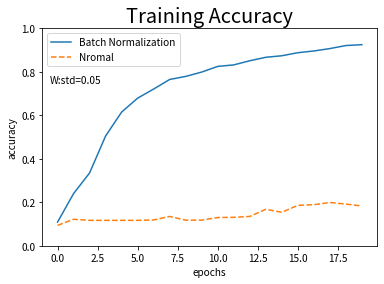

In [42]:
# 作図用のx軸の値
epochs = np.arange(max_epochs)

# 作図
plt.plot(epochs, bn_train_acc_list, label="Batch Normalization") # 正規化あり
plt.plot(epochs, train_acc_list, label="Nromal", linestyle="--") # 正規化なし
plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Training Accuracy", fontsize=20) # タイトル
plt.text(-0.5, 0.75, "W:std=" + str(np.round(weight_init_std, 3))) # メモ
plt.legend() # 凡例
plt.show()

## 6.4 正則化

ここでは、過学習を抑制するテクニックについて学びます。

### 6.4.1 過学習

過学習の主な原因として以下が挙げられます。
- データに対し、パラーメータが多すぎる
- 訓練データが少ない
この二つの要件を満たし、恣意的に過学習を起こしてみます。MNISTデータセットの訓練データを300枚に限定させ、7層のニューラルネットワークを用います。

In [43]:
# 学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズを指定
batch_size = 100

In [44]:
# 荷重減衰の係数を指定
weight_decay_lambda = 0

# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    weight_decay_lambda=weight_decay_lambda # 荷重減衰の係数
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [45]:
# エポック当たりの試行回数を指定
max_epochs = 201

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行回数のカウントを初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(1000000000):
    
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # 損失関数を計算
        train_loss = network.loss(x_train, t_train)
        
        # 値を記録
        train_loss_list.append(train_loss)
        
        # (動作確認も兼ねて)10エポックごとに認識精度を表示
        if epoch_cnt % 10 == 0:
            print(
                "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
                "\ntrain acc:" + str(np.round(train_acc, 3)) + 
                "\ntest acc :" + str(np.round(test_acc, 3))
            )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 最大エポック数に達すると終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
train acc:0.063
test acc :0.07
===========epoch:10===========
train acc:0.323
test acc :0.22
===========epoch:20===========
train acc:0.497
test acc :0.382
===========epoch:30===========
train acc:0.683
test acc :0.465
===========epoch:40===========
train acc:0.797
test acc :0.546
===========epoch:50===========
train acc:0.877
test acc :0.61
===========epoch:60===========
train acc:0.91
test acc :0.671
===========epoch:70===========
train acc:0.943
test acc :0.69
===========epoch:80===========
train acc:0.96
test acc :0.706
===========epoch:90===========
train acc:0.973
test acc :0.711
===========epoch:100===========
train acc:0.99
test acc :0.722
===========epoch:110===========
train acc:0.993
test acc :0.731
===========epoch:120===========
train acc:0.99
test acc :0.727
===========epoch:130===========
train acc:1.0
test acc :0.738
===========epoch:140===========
train acc:1.0
test acc :0.739
===========epoch:150===========
train acc:1.0
test acc :0.738
=

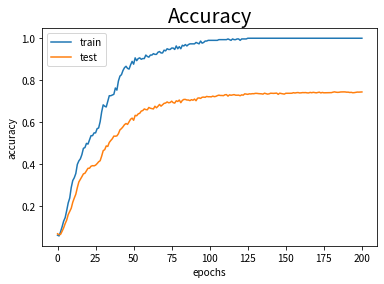

In [46]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_acc_list, label='train') # 訓練データ
plt.plot(epoch_vec, test_acc_list, label='test') # テストデータ
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.legend() # 凡例
plt.show()

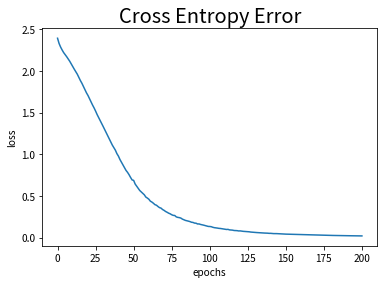

In [47]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_loss_list)
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.title("Cross Entropy Error", fontsize=20) # タイトル
plt.show()

### 6.4.2 Weight decay

ニューラルネットワーク学習とは、損失関数の値
$L$
を小さくするようにパラメータを更新することによって行われます。
過学習の指標である重みの二乗$\mathbf{W}^2$を用いて、損失関数(の計算)に重みの値が大きいと損失関数の値も大きくなるように、
$\frac{1}{2} \lambda \mathbf{W}^2$
を加えることにします。これによって、交差エントロピー誤差とともに
$\frac{1}{2} \lambda \mathbf{W}^2$
これにより大きな重みに対してペナルティを与えているわけです。
$\lambda$
は正則化の強さを調整するハイパーパラメータです。
ここで係数の
$\frac{1}{2}$
は、
$\frac{1}{2} \lambda \mathbf{W}^2$
を
$\mathbf{W}$
で微分したときに項を扱いやすくする(指数の2を打ち消す)ための定数です。
逆伝播では、
$\lambda \mathbf{W}$
を伝播します。
では、実装を確認してみます。

In [48]:
# 荷重減衰の係数を指定
weight_decay_lambda = 0.1

# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    weight_decay_lambda=weight_decay_lambda# 荷重減衰の係数
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [49]:
# エポック当たりの試行回数を指定
max_epochs = 201

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行回数のカウントを初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(1000000000):
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # 損失関数を計算
        train_loss = network.loss(x_train, t_train)
        
        # 値を記録
        train_loss_list.append(train_loss)
        
        # (動作確認も兼ねて)10エポックごとに認識精度を表示
        if epoch_cnt % 10 == 0:
            print(
                "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
                "\ntrain acc:" + str(np.round(train_acc, 3)) + 
                "\ntest acc :" + str(np.round(test_acc, 3))
            )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 最大エポック数に達すると終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
train acc:0.113
test acc :0.102
===========epoch:10===========
train acc:0.197
test acc :0.124
===========epoch:20===========
train acc:0.28
test acc :0.161
===========epoch:30===========
train acc:0.357
test acc :0.212
===========epoch:40===========
train acc:0.417
test acc :0.29
===========epoch:50===========
train acc:0.457
test acc :0.338
===========epoch:60===========
train acc:0.49
test acc :0.378
===========epoch:70===========
train acc:0.493
test acc :0.384
===========epoch:80===========
train acc:0.517
test acc :0.405
===========epoch:90===========
train acc:0.573
test acc :0.451
===========epoch:100===========
train acc:0.607
test acc :0.482
===========epoch:110===========
train acc:0.633
test acc :0.502
===========epoch:120===========
train acc:0.66
test acc :0.517
===========epoch:130===========
train acc:0.69
test acc :0.547
===========epoch:140===========
train acc:0.693
test acc :0.546
===========epoch:150===========
train acc:0.707
test acc

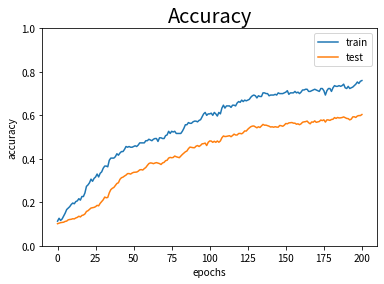

In [50]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_acc_list, label='train') # 訓練データ
plt.plot(epoch_vec, test_acc_list, label='test') # テストデータ
plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.legend() # 凡例
plt.show()

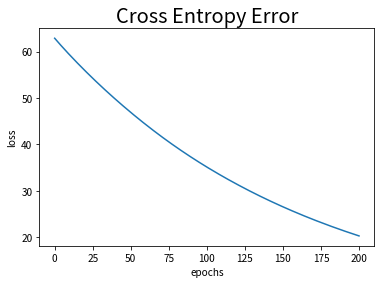

In [51]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_loss_list)
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.title("Cross Entropy Error", fontsize=20) # タイトル
plt.show()

### 6.4.3 Dropout

Dropoutは、ニューロンをランダムに消去しながら学習する手法です。学習の際に隠れ層のニューロンを一部消去することで表現力を一時的に落とすことで過学習を抑制します。また、テスト時には各ニューロンの出力に対して、学習時に消去した割合を乗算して出力します。実装を見てみます。

In [52]:
# バッチサイズを指定
batch_size = 5

# ニューロン数を指定
node_num = 5

# (処理のイメージ用に)ランダムに整数を生成
x = np.random.randint(0, 10, (batch_size, node_num))
print(x)

[[0 2 9 3 4]
 [7 5 2 4 6]
 [8 8 1 4 3]
 [2 3 8 1 2]
 [1 1 6 2 9]]


In [53]:
# Dropout ratioを指定
dropout_ratio = 0.5

# ランダムに0から1の値を生成
random_data = np.random.rand(*x.shape)
print(np.round(random_data, 3))

# 一定の値以上の要素を検索
mask = random_data > dropout_ratio
print(mask)

[[0.916 0.87  0.866 0.427 0.975]
 [0.487 0.949 0.619 0.01  0.651]
 [0.636 0.487 0.164 0.223 0.351]
 [0.77  0.234 0.032 0.078 0.376]
 [0.808 0.024 0.389 0.095 0.015]]
[[ True  True  True False  True]
 [False  True  True False  True]
 [ True False False False False]
 [ True False False False False]
 [ True False False False False]]


In [54]:
# ノードを消去
print(x * mask)

[[0 2 9 0 4]
 [0 5 2 0 6]
 [8 0 0 0 0]
 [2 0 0 0 0]
 [1 0 0 0 0]]


In [55]:
# Dropoutの実装
class Dropout:
    
    # インスタンスの定義
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    # 順伝播メソッドの定義
    def forward(self, x, train_flg=True):
        # ランダムにニューロンを消去
        if train_flg: # 訓練時
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else: # テスト時
            return x * (1.0 - self.dropout_ratio)
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        return dout * self.mask

In [56]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [57]:
# 学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズを指定
batch_size = 100

In [58]:
# 消去するニューロンの割合を指定
dropout_ratio = 0.20

# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNetExtend(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    use_dropout=True, # Dropoutの設定
    dropout_ration=dropout_ratio # ニューロンを消去する割合
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [59]:
# エポック当たりの試行回数を指定
max_epochs = 501

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行回数のカウントを初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
train_acc_list = []
test_acc_list = []

for i in range(1000000000):
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # (動作確認も兼ねて)10エポックごとに認識精度を表示
        if epoch_cnt % 10 == 0:
            print(
                "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
                "\ntrain acc:" + str(np.round(train_acc, 3)) + 
                "\ntest acc :" + str(np.round(test_acc, 3))
            )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 最大エポック数に達すると終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
train acc:0.143
test acc :0.134
===========epoch:10===========
train acc:0.193
test acc :0.17
===========epoch:20===========
train acc:0.273
test acc :0.218
===========epoch:30===========
train acc:0.29
test acc :0.244
===========epoch:40===========
train acc:0.303
test acc :0.26
===========epoch:50===========
train acc:0.333
test acc :0.272
===========epoch:60===========
train acc:0.31
test acc :0.265
===========epoch:70===========
train acc:0.313
test acc :0.265
===========epoch:80===========
train acc:0.313
test acc :0.264
===========epoch:90===========
train acc:0.34
test acc :0.286
===========epoch:100===========
train acc:0.39
test acc :0.314
===========epoch:110===========
train acc:0.417
test acc :0.34
===========epoch:120===========
train acc:0.417
test acc :0.355
===========epoch:130===========
train acc:0.43
test acc :0.37
===========epoch:140===========
train acc:0.44
test acc :0.377
===========epoch:150===========
train acc:0.447
test acc :0.3

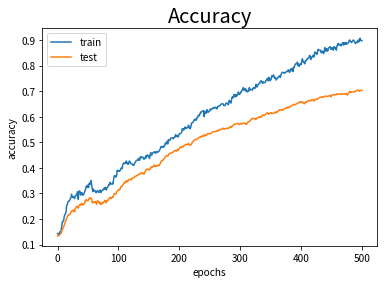

In [60]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_acc_list, label='train') # 訓練データ
plt.plot(epoch_vec, test_acc_list, label='test') # テストデータ
#plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.legend() # 凡例
plt.show()

## 6.5 ハイパーパラメータ

### 6.5.3 ハイパーパラメータ最適化の実装

In [65]:
# エポックあたりの試行回数を指定
max_epoch = 50

# ミニバッチサイズを指定
batch_size = 100

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 訓練データ数
train_size = x_train.shape[0]

# 全データ数に対するバッチデータ数の割合
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

# 試行回数を計算
max_iter = int(max_epoch * iter_per_epoch)
print(max_iter)

5.0
250


In [66]:
# ハイパーパラメータの範囲を指定してランダムに値を生成
weight_decay_lambda = 10 ** np.random.uniform(-8, -4) # 荷重減衰の係数
lr = 10 ** np.random.uniform(-6, -2) # 学習率
print(weight_decay_lambda)
print(lr)

9.888691457692582e-05
4.394681974269258e-06


In [67]:
# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    weight_decay_lambda=weight_decay_lambda # 荷重減衰の係数
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [68]:
# 認識精度の受け皿を初期化
val_acc_list = []
train_acc_list = []

# ミニバッチデータごとに処理
for i in range(max_iter):
    
    # ランダムにバッチデータを抽出
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        val_acc = network.accuracy(x_val, t_val)
        train_acc = network.accuracy(x_train, t_train)
        
        # 値を記録
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)
        
# (動作確認も兼ねて)認識精度を表示
print(
    "=============== Result ===============" + 
    "\nlr:" + str(lr) + ", lambda:" + str(weight_decay_lambda) + 
    "\nval acc  " + ":" + str(np.round(val_acc, 5)) + 
    "\ntrain acc" + ":" + str(np.round(train_acc, 5))
)

=============== Result ===============
lr:4.394681974269258e-06, lambda:9.888691457692582e-05
val acc  :0.792
train acc:0.948


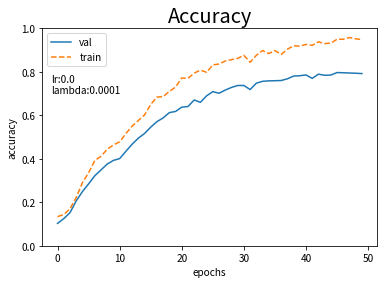

In [69]:
# 作図用のx軸の値
epochs = np.arange(max_epoch)

# 作図
plt.plot(epochs, val_acc_list, label='val') # 訓練データ
plt.plot(epochs, train_acc_list, label='train', linestyle='--') # テストデータ
plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.text(-1, 0.7, "lr:" + str(np.round(lr, 5)) + "\nlambda:" + str(np.round(weight_decay_lambda, 5))) # メモ
plt.legend() # 凡例
plt.show()

val acc:0.11 | lr:6.782918434907295e-06, weight decay:4.738846412091972e-05
val acc:0.73 | lr:0.00584154990922059, weight decay:4.9844763475171316e-06
val acc:0.17 | lr:1.683111003532643e-06, weight decay:3.606087427245861e-08
val acc:0.1 | lr:0.0004135454469973625, weight decay:5.533600924103195e-07
val acc:0.07 | lr:6.51090713362828e-06, weight decay:4.676519924402064e-08
val acc:0.09 | lr:0.000308373936290502, weight decay:7.993342434300684e-06
val acc:0.13 | lr:9.447293984299397e-05, weight decay:3.6245111052978584e-06
val acc:0.16 | lr:2.239259796057505e-05, weight decay:1.455408511698765e-05
val acc:0.79 | lr:0.00964971260975801, weight decay:8.288025064554803e-08
val acc:0.72 | lr:0.006498972266974728, weight decay:1.1081012890984517e-05
val acc:0.09 | lr:5.01871042891723e-06, weight decay:1.0688005394569503e-08
val acc:0.08 | lr:2.4256509654690596e-06, weight decay:3.314040672183465e-07
val acc:0.11 | lr:4.473326934990835e-06, weight decay:1.123281592960802e-07
val acc:0.27 | l

Best-15(val acc:0.52) | lr:0.0027178764962327915, weight decay:2.06937954736739e-05
Best-16(val acc:0.38) | lr:0.0010973022779503247, weight decay:5.771746843562241e-07
Best-17(val acc:0.35) | lr:0.001178078932474982, weight decay:5.66619108219059e-06
Best-18(val acc:0.34) | lr:0.00116524172690276, weight decay:9.921883134774983e-08
Best-19(val acc:0.3) | lr:0.0008860905860208294, weight decay:1.4330434586021224e-06
Best-20(val acc:0.29) | lr:0.0021191284966552734, weight decay:2.6785310626482935e-07


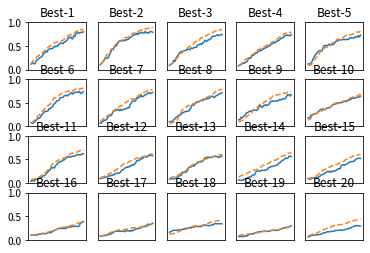

In [70]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from utils.mnist import load_mnist
from utils.multi_layer_net import MultiLayerNet
from utils.util import shuffle_dataset
from utils.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()